This notebook examines the results from three modifications to the previous MESA inlists

* a new set of wind models
* a new stopping condition to avoid runaway critically rotating stars
* tracking the chemical mixing timescale

### Prelude

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9
from scipy.signal import find_peaks
from scipy.integrate import simpson

import mesa_reader as mr
import mesaPlot as mp

import sys
sys.path.append('..')
from src.constants import (Z_SUN, MASS_U, PERIOD_U, AGE_U, SMA_U, RADIUS_U, TEMP_U, LUMINOSITY_U, 
                           T_H)
from src.star import (eggleton_rl1_radius, marchant_l2_radius, a_from_p, p_from_a, tau_kh, fix_unit,
                      ToutMassLuminosityRelation, ToutMassRadiusRelation, 
                      HurleyMassLuminosityRelation, HurleyMassRadiusRelation)


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
plt.style.use('./plotstyle.mplstyle')

In [3]:
def tau_es1(m, r, tau_kh, omega):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    tau_kh = fix_unit(tau_kh, u.yr)
    omega *= u.s**-1
    tau_es = tau_kh * ct.G * m / (omega**2 * r**3)   
    return tau_es.to(u.yr).value
    

### References

Gottlieb, O., Renzo, M., Metzger, B. D., Goldberg, J. A. & Cantiello, M., *She's got her mother's hair: end-to-end collapsar simulations unveil the origin of black holes' magnetic field*, 2024, [arXiv:2407.16745](https://ui.adsabs.harvard.edu/abs/2024arXiv240716745G/abstract)  
Nugis, T. & Lamers, H. J. G. L. M., *Mass-loss rates of Wolf-Rayet stars as a function of stellar parameters*, 2000, [A&A 360, 227](https://ui.adsabs.harvard.edu/abs/2000A%26A...360..227N/abstract)  
Vink, J. S., de Koter, A. & Lamers, H. J. G. L. M., *New theoretical mass-loss rates of O and B Stars*, 2000, [A&A, 362, 295](https://ui.adsabs.harvard.edu/abs/2000A%26A...362..295V/abstract)

### Definitions

In [4]:
mix_dict = dict(
    radiative=-1,
    none=0,
    convective=1,
    overshoot=2,
    semiconvective=3,
    thermohaline=4,
    rotation=5,
    rayleigh_taylor=6,
    minimum=7,
    anonymous=8,
    leftover=9,
    phase_sep=10
    )
mix_dict = {v: k for k, v in mix_dict.items()}

In [5]:
def get_model_dict(grid_folder):
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [6]:
def monitor(w, h, axes, c, col_indices=[0, 1, 2, 3, 4, 5, 6]):
    #fig, axes = plt.subplots(1, 7, figsize=(36, 4), sharex=True)
    #fig.subplots_adjust(wspace=0.5)

    omg_ax, wct_ax, vrt_ax, mss_ax, rad_ax, lum_ax, he4_ax = col_indices 

    axes[omg_ax].plot(h.star_age/1e6, h.surf_avg_v_rot/(2*np.pi*h.radius*u.Rsun.to(u.km)/(2*np.pi)), lw=1, c=c)     
    axes[vrt_ax].plot(h.star_age/1e6, h.surf_avg_v_rot, lw=1, c=c)     
    axes[rad_ax].plot(h.star_age/1e6, h.radius, lw=1, c=c)    
    axes[wct_ax].plot(h.star_age/1e6, h.surf_avg_omega_div_omega_crit, lw=1, c=c)        
    axes[mss_ax].plot(h.star_age/1e6, h.star_mass, lw=1, c=c)    
    axes[lum_ax].plot(h.star_age/1e6, h.log_L, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.surface_he4, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.center_h1, lw=1, c=c, ls='--') 
    
    i_critrot_peaks = find_peaks(h.surf_avg_omega_div_omega_crit, height=1, distance=100, prominence=0.1)[0]
    t_critrot_peaks= h.star_age[i_critrot_peaks]/1e6
    for t in t_critrot_peaks:
        # don't plot peaks (too many in one panel)
        continue
        for ax in axes:
            y0, y1 = ax.get_ylim()
            ax.vlines(t, 0, y1, lw=1, color='k', ls='-')
            try:
                ax.vlines(h.star_age[1500]/1e6, 0, y1, lw=1, color='k', ls='--')
            except IndexError:
                pass
            ax.set_ylim(y0, y1)
            
    #axes[omg_ax].set_ylabel('$\\Omega$')
    #axes[vrt_ax].set_ylabel('$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$')
    #axes[rad_ax].set_ylabel('$R/\\mathrm{R}_\\odot$')
    #axes[wct_ax].set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
    #axes[mss_ax].set_ylabel('$M/\\mathrm{M}_\\odot$')
    #axes[lum_ax].set_ylabel('$L/\\mathrm{L}_\\odot$')
    #axes[he4_ax].set_ylabel('S.He4 / C. H1')
    
    if h.center_h1[-1] < 1e-7:
        status = 'DONE'
    else:
        status = 'RUNNING'
        
    p = 2 * np.pi / float(w) / (24*60*60)
    handle = Line2D((-1, -1), (-1, -1), linestyle='-', color=c, 
                    label=f'${p:.2f}\\,\\mathrm{{d}}$ ({np.log10(h.center_h1[-1]):.1f}, {len(h.star_age)} steps)')
    #axes[3].text(0.5, 1.1, f'$m={m:.1f}\\,\\mathrm{{M}}_\\odot, P={p:.2f}\\,\\mathrm{{d}}, \\Omega={w:.1e}\\,\\mathrm{{rad}}\\,\\mathrm{{s}}^{{-1}},$ {len(h.star_age)} steps ({status})', 
    #             rotation=0, va='center', ha='right', fontsize=28, transform=axes[3].transAxes)   
    
    return axes, handle

### Analysis

In [7]:
ROOT = Path.cwd().parent
GRID_FOLDER = ROOT/'mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test'

In [8]:
model_dict = get_model_dict(GRID_FOLDER)
model_dict

{'65.0': {'1.28': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05'),
  '0.48': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04'),
  '4.04': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05'),
  '1.65': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05'),
  '2.80': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05'),
  '0.89': PosixPath('/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05')}}

In [9]:
all_paths = [model_dict[k1][k2] for k1 in model_dict.keys() for k2 in model_dict[k1].keys()] 

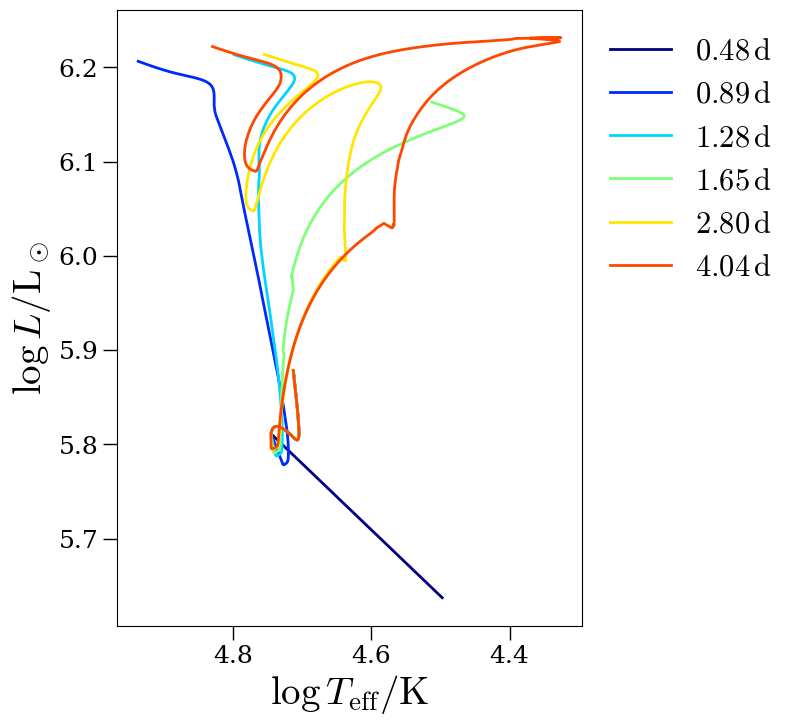

In [10]:
fig, ax = plt.subplots(figsize=(6, 8))

_c = 0
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for i, p_key in enumerate(p_keys):
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        model_path = p_dict[p_key]
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        #ax.scatter(h.log_Teff, h.log_L, c=h.surface_he4)
        ax.plot(h.log_Teff, h.log_L, color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$')
        #ax.text(h.log_Teff[-1], h.log_L[-1], f'${p:.2f}\\,\\mathrm{{d}}$',
        #        ha='center', va='bottom', transform=ax.transData, fontsize=18)
        _c += 1
            
ax.invert_xaxis()
ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$\\Omega/\\Omega_\\mathrm{crit}$')

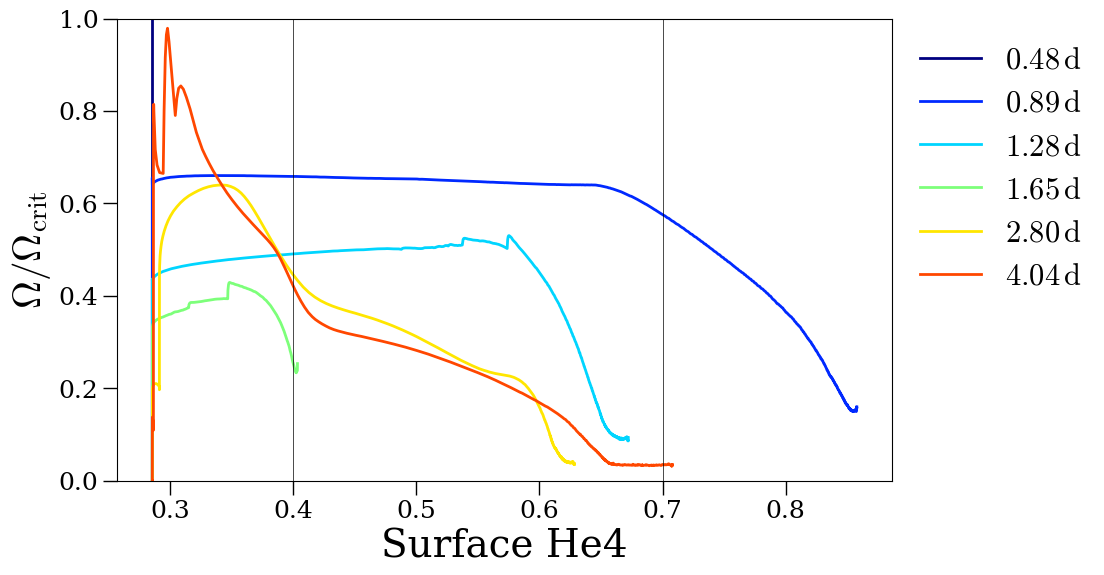

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.surface_he4, h.surf_avg_omega_div_omega_crit, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$')
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = (0, 1)
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$\\Omega/\\Omega_\\mathrm{crit}$')

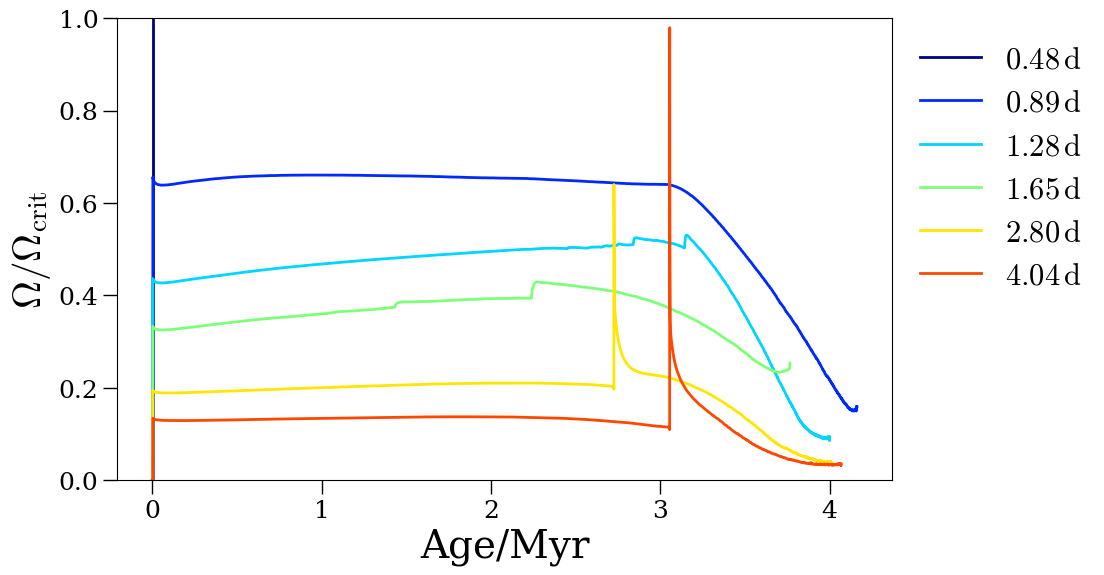

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.star_age/1e6, h.surf_avg_omega_div_omega_crit, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$')
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = (0, 1)
#ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
#ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$M/\\mathrm{M}_\\odot$')

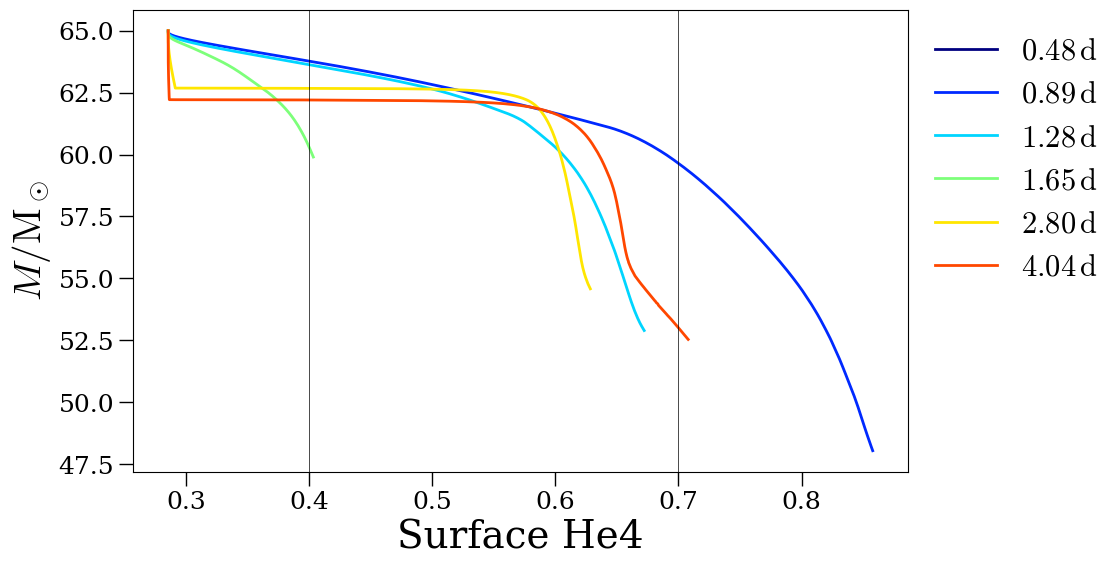

In [13]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.surface_he4, h.star_mass, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$')
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = ax.get_ylim()
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$M/\\mathrm{M}_\\odot$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

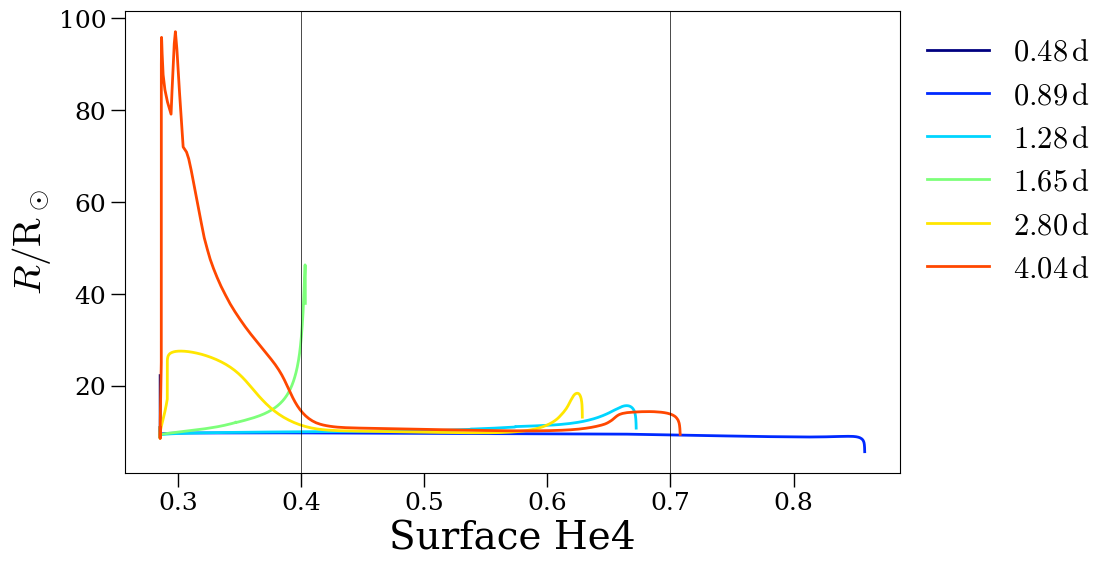

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.surface_he4, h.radius, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$')
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = ax.get_ylim()
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

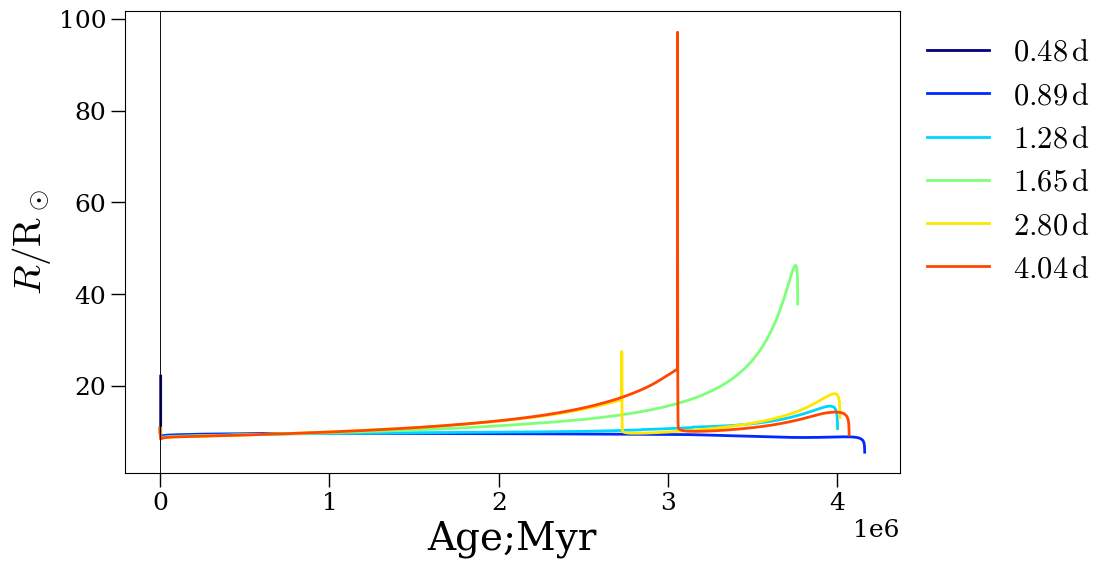

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.star_age, h.radius, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$')
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = ax.get_ylim()
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

ax.set_xlabel('Age;Myr')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

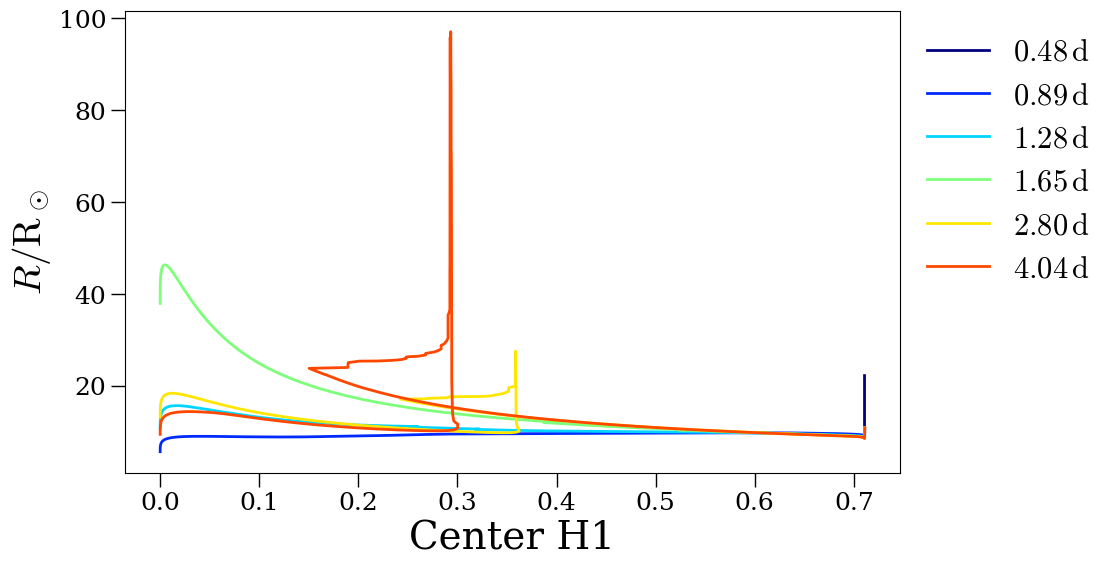

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.center_h1, h.radius, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$', lw=2)
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

#ylim = (-6.5, -4.5)
#ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
#ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
#ax.set_ylim(ylim)

ax.set_xlabel('Center H1')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

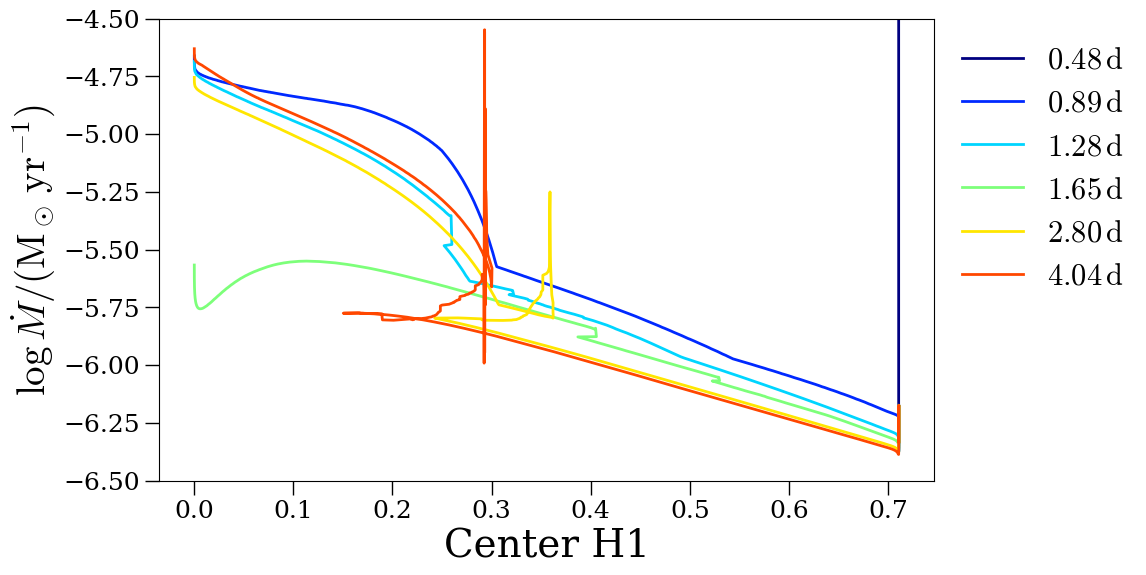

In [17]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.center_h1, h.log_abs_mdot, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$', lw=2)
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = (-6.5, -4.5)
#ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
#ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

ax.set_xlabel('Center H1')
ax.set_ylabel('$\\log\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

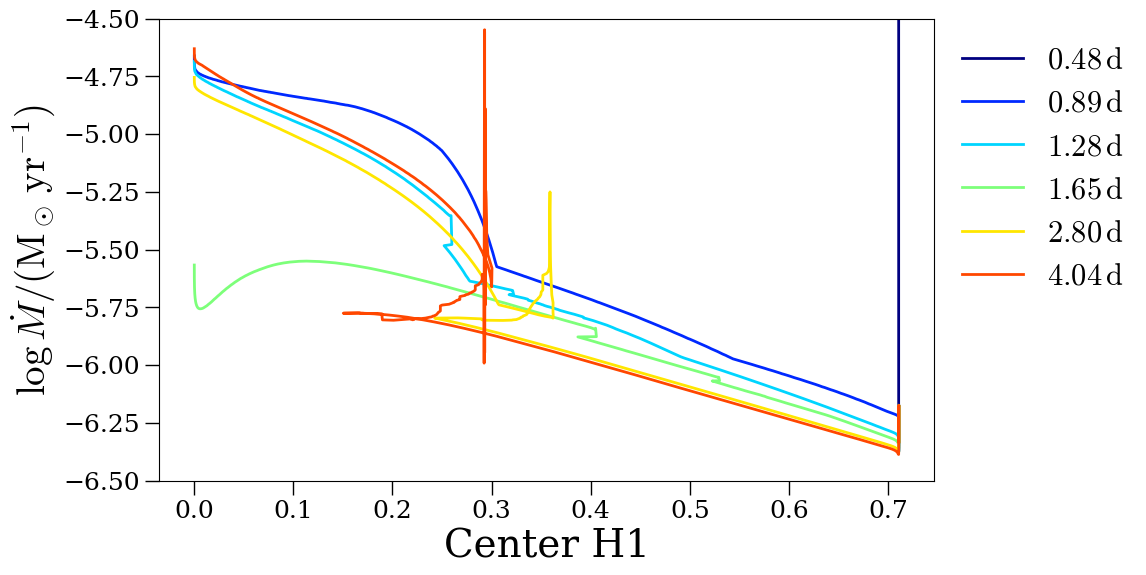

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.center_h1, h.log_abs_mdot, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$', lw=2)
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = (-6.5, -4.5)
#ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
#ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

ax.set_xlabel('Center H1')
ax.set_ylabel('$\\log\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, 'Luminosity (erg/s)')

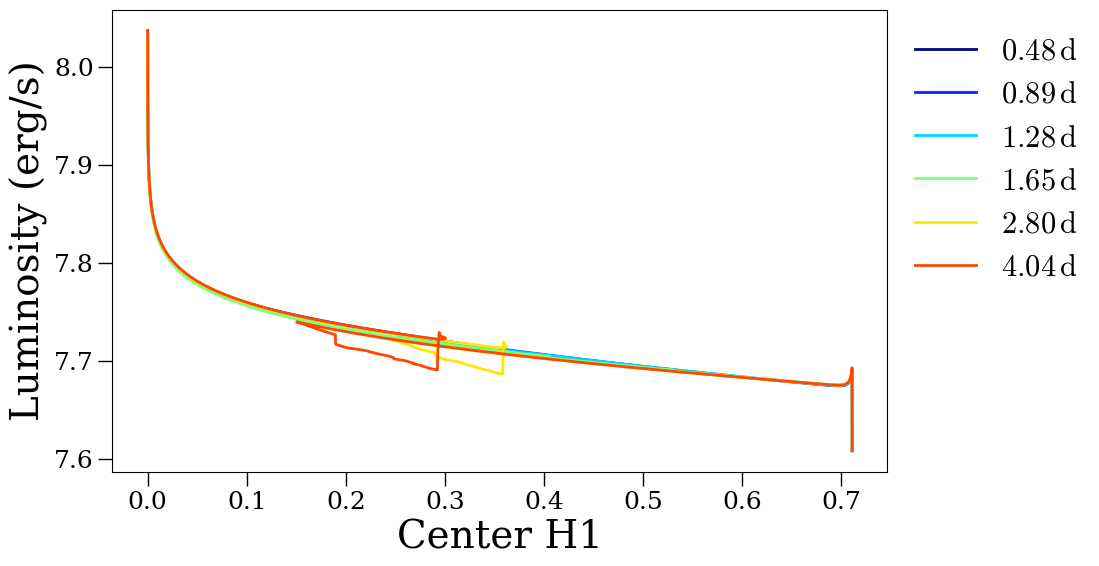

In [19]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.center_h1, h.log_center_T, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$', lw=2)
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

#ylim = (5.5, 6.3)
#ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
#ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
#ax.set_ylim(ylim)

ax.set_xlabel('Center H1')
ax.set_ylabel('Luminosity (erg/s)')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, 'Luminosity (erg/s)')

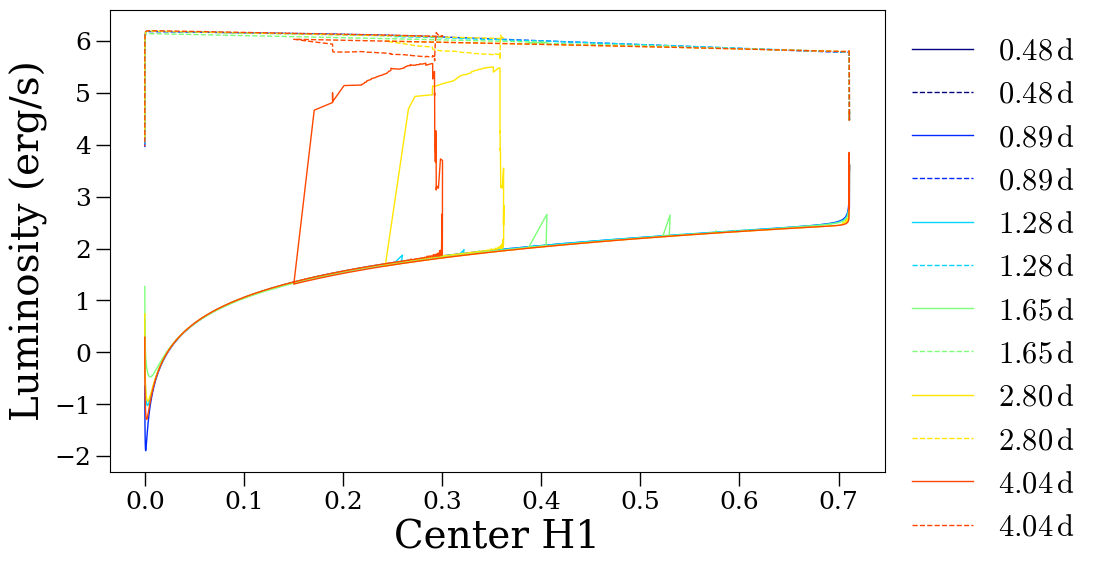

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.center_h1, h.pp, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$', lw=1)
        ax.plot(h.center_h1, h.cno, ls='--',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$', lw=1)
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

#ylim = (5.5, 6.3)
#ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
#ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
#ax.set_ylim(ylim)

ax.set_xlabel('Center H1')
ax.set_ylabel('Luminosity (erg/s)')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

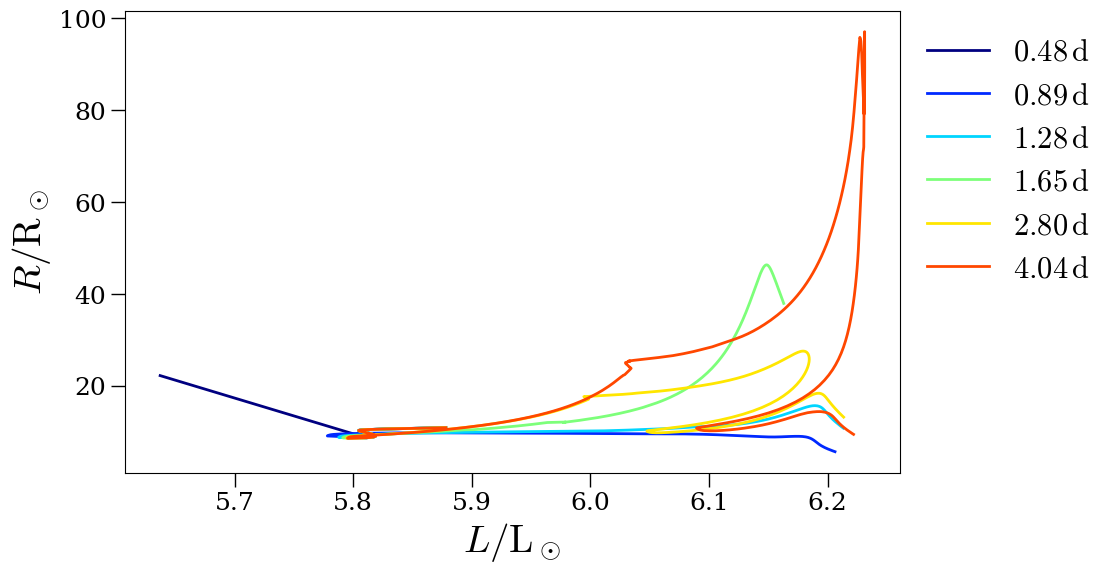

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(h.log_L, h.radius, ls='-',color=c, label=f'${p:.2f}\\,\\mathrm{{d}}$')
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = ax.get_ylim()
#ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
#ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

ax.set_xlabel('$L/\\mathrm{L}_\\odot$')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05


/tmp/ipykernel_975878/3036216359.py:21: RuntimeWarning: invalid value encountered in divide
  h.surf_avg_v_rot / (4*np.pi**2 * h.radius * h.surf_avg_omega_div_omega_crit),


/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$\\Omega_\\mathrm{crit}\\,(\\mathrm{rad}\\,\\mathrm{s}^{-1})$')

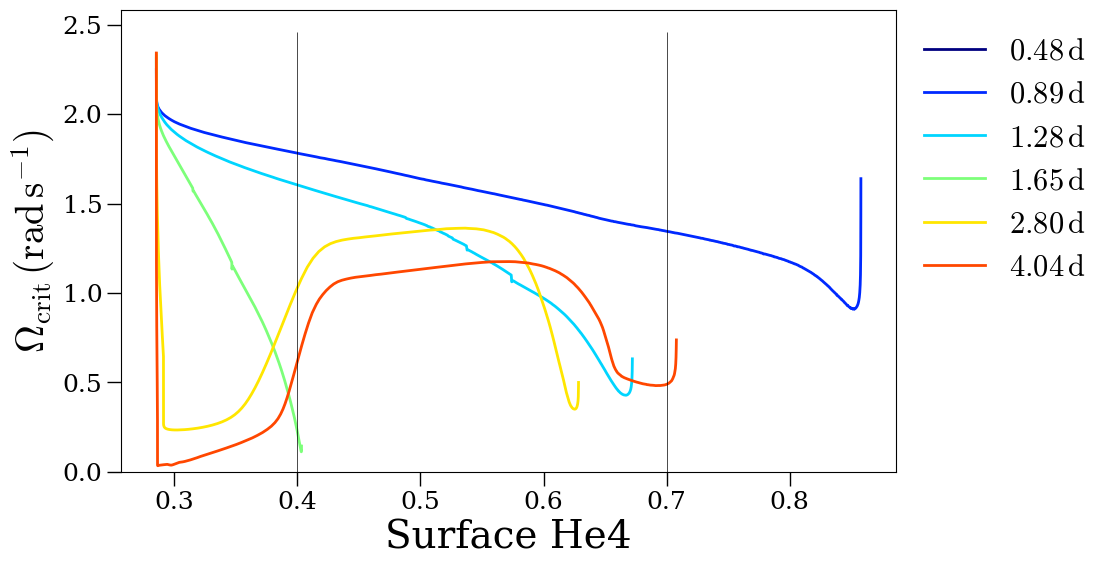

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        #handles.append(ax.scatter([], [], marker='o', color=c, 
                                  #label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        h = mr.MesaData(str(model_path/'LOGS/history.data'))
        ax.plot(
            h.surface_he4, 
            h.surf_avg_v_rot / (4*np.pi**2 * h.radius * h.surf_avg_omega_div_omega_crit), 
            ls='-',
            color=c,
            label=f'${p:.2f}\\,\\mathrm{{d}}$'
        )
        _c += 1
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1,1))

ylim = ax.get_ylim()
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(0)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$\\Omega_\\mathrm{crit}\\,(\\mathrm{rad}\\,\\mathrm{s}^{-1})$')

In [23]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [24]:
def Teff_jump(Z):
    return 1e3*(61.2e0 + 2.59e0*(-13.636e0 + 0.889e0*np.log10(Z/0.014)))

In [25]:
np.log10(Teff_jump(0.001))

4.366306919470288

In [26]:
test_case = model_dict['65.0']['2.80']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

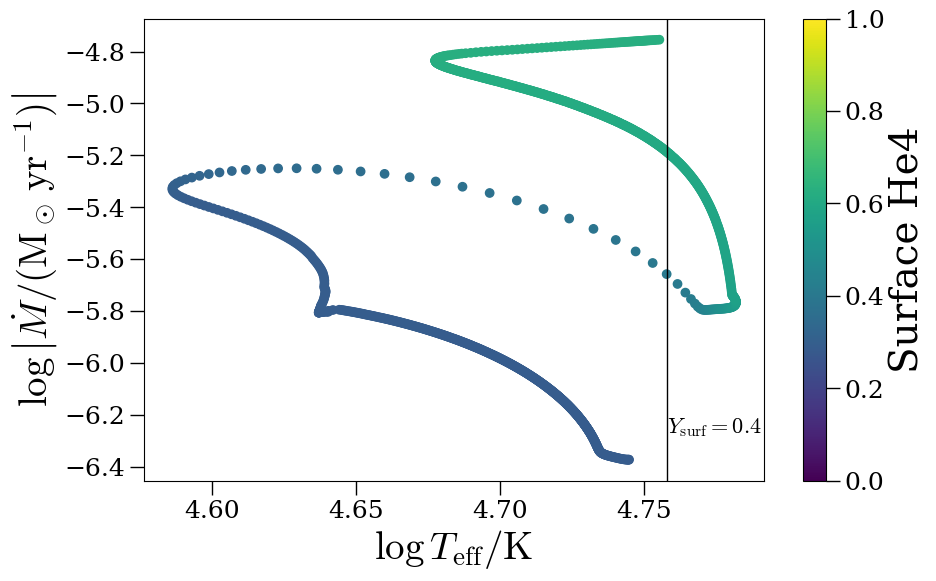

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

x = h.log_Teff
zams_i = np.where(h.surf_avg_omega_div_omega_crit>0)[0][0]
he04_i = np.where(h.surface_he4 >= 0.4)[0][0]
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]
c = cm.viridis(h.surface_he4[zams_i:])
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]

#ax.plot(x, normarr(h.star_mass), 'k-', lw=1, label='normalized $\\log M$')
#ax.plot(x, normarr(h.radius), 'r-', lw=1, label='normalized $\\log R$')
#ax.plot(x, h.surface_he4, 'g-', lw=1, label='Surf. He4')
#ax.plot(x, h.center_h1, 'g--', lw=1, label='Center. H1')
#ax.plot(x, h.surf_avg_omega_div_omega_crit, 'b-', lw=1, label='$\\Omega/\\Omega_\\mathrm{c}$')
ax.scatter(x[zams_i:], h.log_abs_mdot[zams_i:], c=c, label='normalized $\\log \\dot{M}$')

ylim = ax.get_ylim()
ax.vlines(x[he04_i], *ylim, color='k', ls='-', lw=1)
ax.text(x[he04_i], -6.25, '$Y_\\mathrm{surf}=0.4$', ha='left', va='center', transform=ax.transData,
        fontsize=16)
#ax.vlines(x[he07_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he07_i], -6.25, '$Y_\\mathrm{surf}=0.7$', ha='left', va='center', transform=ax.transData,
        #fontsize=16)
ax.set_ylim(*ylim)

#ax.hlines(0.4, 0, 3.5, color='k', ls='--', lw=1)
#ax.hlines(0.7, 0, 3.5, color='k', ls='--', lw=1)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')

#ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0,1))
cb = fig.colorbar(ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cm.viridis), ax=ax)
cb.set_label('Surface He4')


#ax.set_xlim(0, 1)
#ax.set_yscale('log')
#ax.invert_yaxis()

#ax.set_yscale('log')

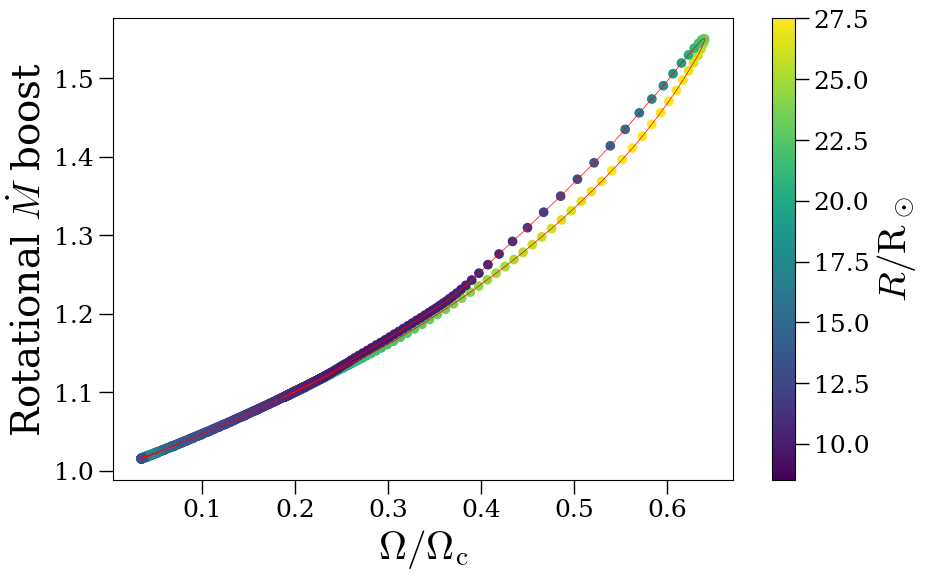

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.viridis

y = h.rotational_mdot_boost[i_start:i_end:i_step]
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.radius[i_start:i_end:i_step]
c = cmap(normarr(cdata))

ax.scatter(x, y, c=c, alpha=1)
ax.plot(x, y, c='r', lw=0.5, alpha=1)
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('Rotational $\\dot{M}$ boost')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('$R/\\mathrm{R}_\\odot$')


In [29]:
pl = ax.scatter([], [], color='b', ls='-', marker='x', s=100, label='Non-rotational')

In [30]:
pl.get_label()

'Non-rotational'

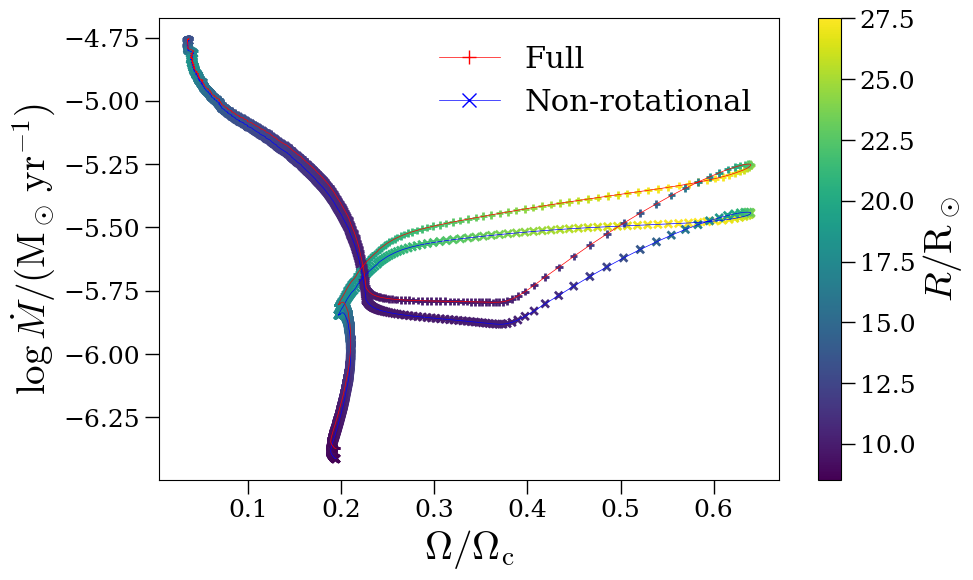

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.viridis

y1 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
y2 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step])#-10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.radius[i_start:i_end:i_step]
c = cmap(normarr(cdata))

ax.scatter(x, y1, c=c, marker='x', alpha=1, s=30)
ax.plot(x, y1, c='b', lw=0.5, alpha=1)
ax.scatter(x, y2, c=c, marker='+', alpha=1, s=30)
ax.plot(x, y2, c='r', lw=0.5, alpha=1)
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('$R/\\mathrm{R}_\\odot$')

handles = []
handles.append(Line2D([], [], color='r', ls='-', lw=0.5, marker='+', ms=10, label='Full'))
handles.append(Line2D([], [], color='b', ls='-', lw=0.5, marker='x', ms=10, label='Non-rotational'))
ax.legend(handles=handles, frameon=False)


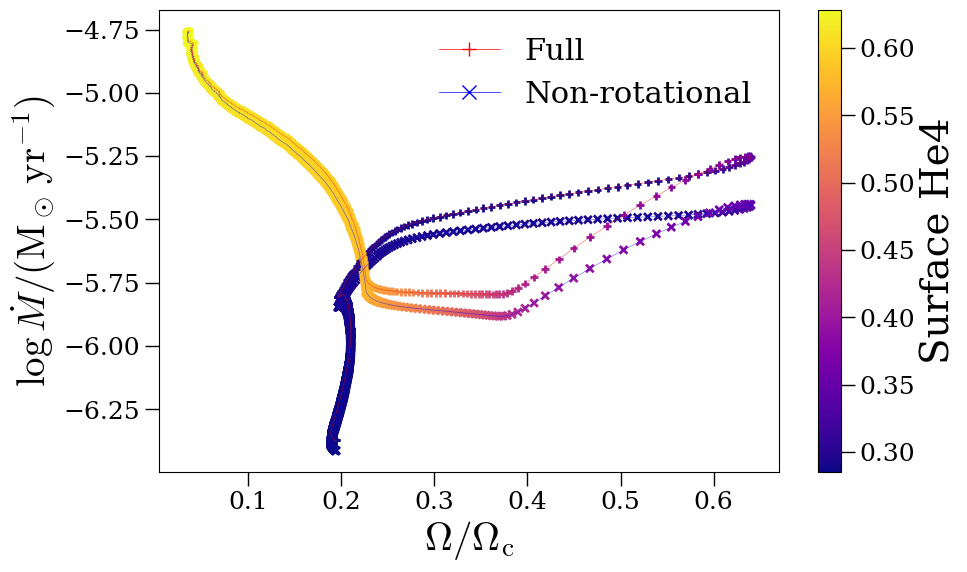

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.plasma

y1 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
y2 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step])#-10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.surface_he4[i_start:i_end:i_step]
c = cmap(normarr(cdata))
he04_i = np.where(h.surface_he4 <= 0.4)[0][0]

ax.scatter(x, y1, c=c, marker='x', alpha=1, s=30)
ax.plot(x, y1, c='b', lw=0.5, alpha=0.5)
ax.scatter(x, y2, c=c, marker='+', alpha=1, s=30)
ax.plot(x, y2, c='r', lw=0.5, alpha=0.5)

ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('Surface He4')

handles = []
handles.append(Line2D([], [], color='r', ls='-', lw=0.5, marker='+', ms=10, label='Full'))
handles.append(Line2D([], [], color='b', ls='-', lw=0.5, marker='x', ms=10, label='Non-rotational'))
ax.legend(handles=handles, frameon=False)


In [33]:
mm = mp.MESA()

In [34]:
mm.loadHistory(f=str(model_dict['65.0']['4.04']/'LOGS'))
mm.scrubHistory()

AttributeError: No attribute head_names

In [169]:
p = mp.plot()

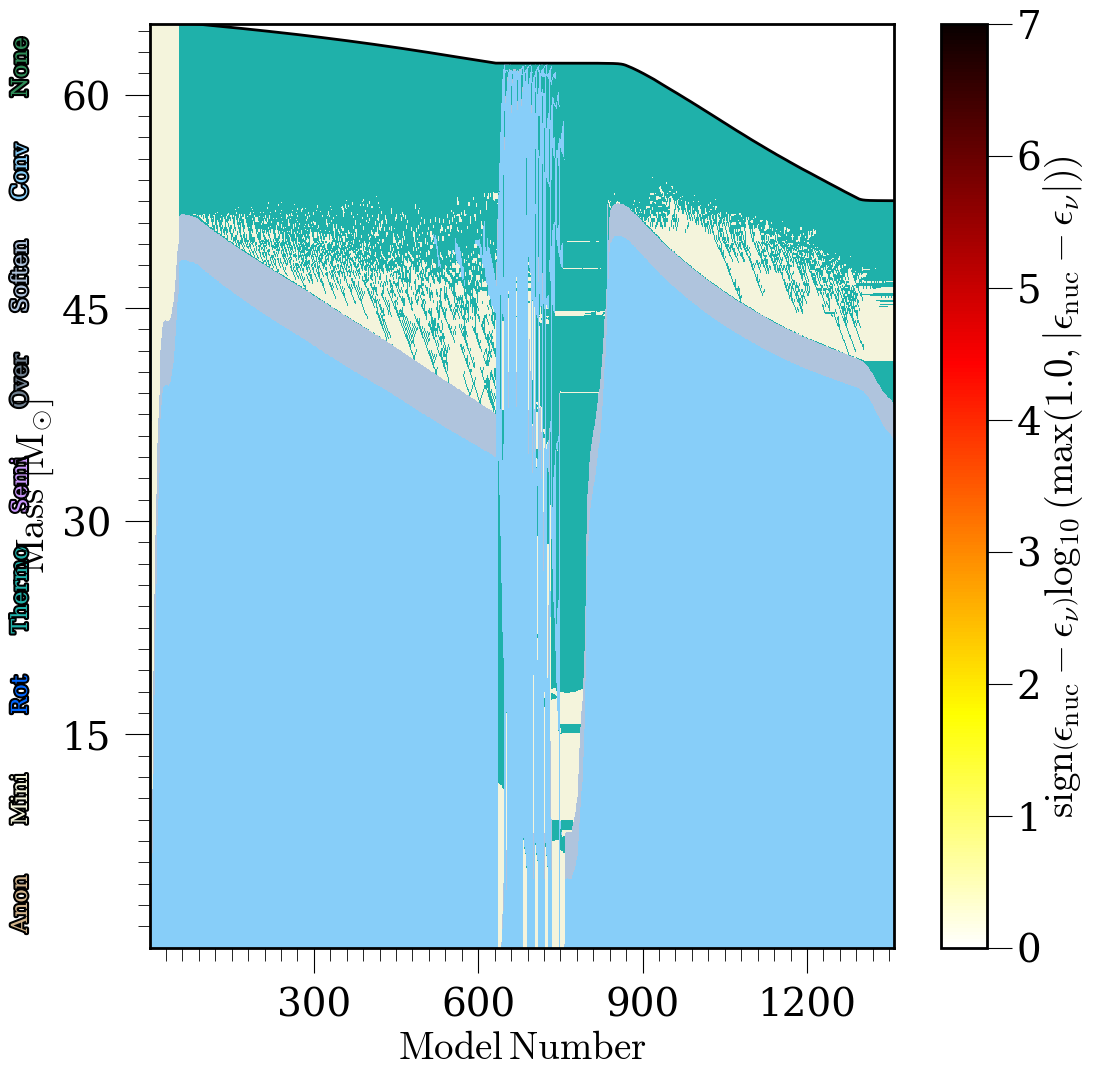

In [170]:
p.plotKip(mm)

Text(0.5, 1.0, 'M=65.0, P=4.04')

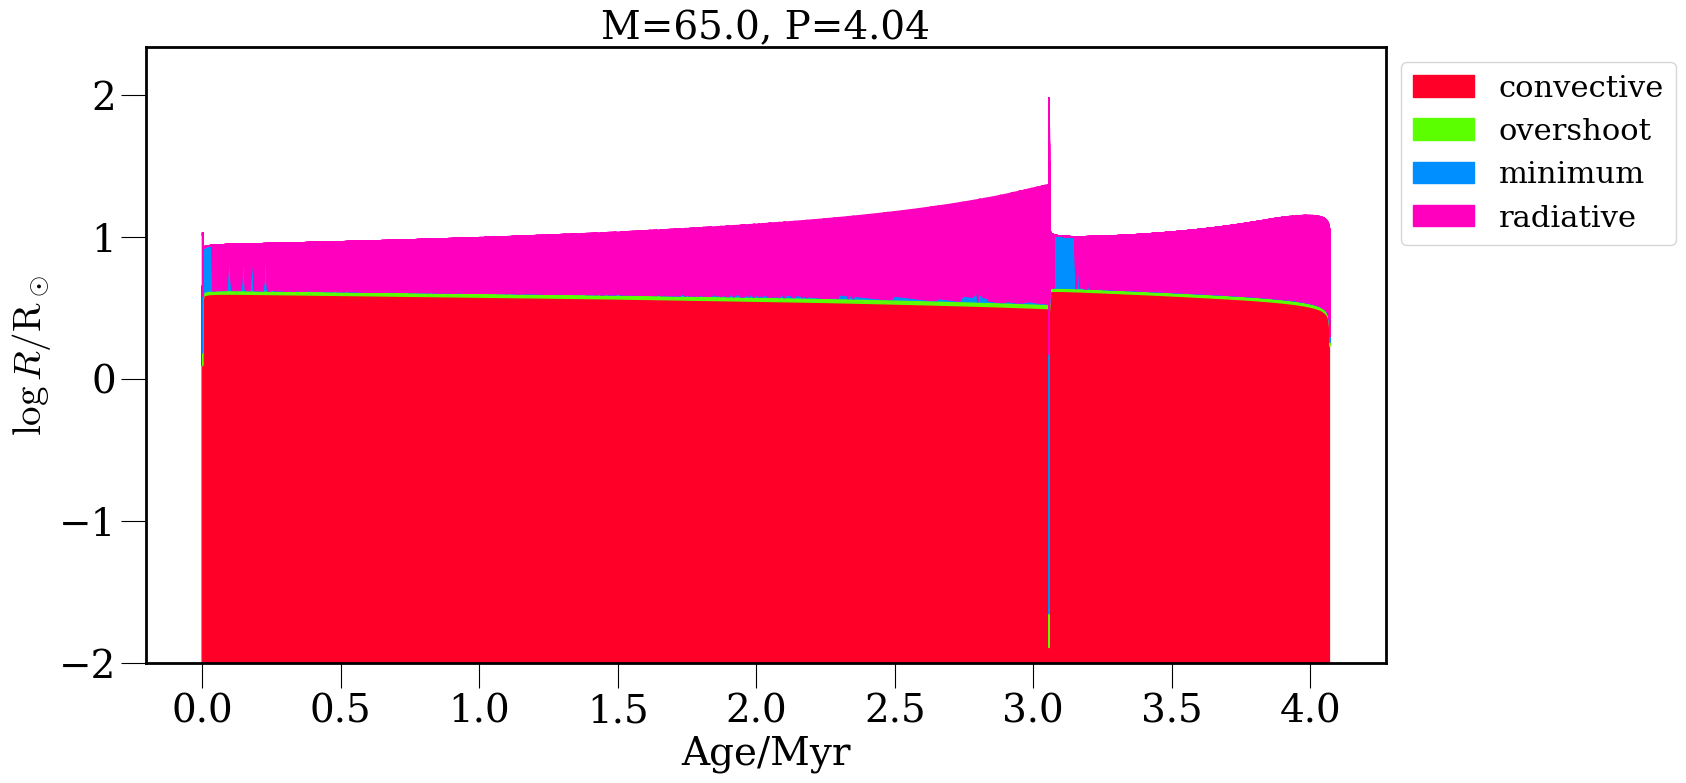

In [93]:
m_key = '65.0'
p_key = '4.04'
model = model_dict[m_key][p_key]
h = mr.MesaData(str(model/'LOGS/history.data'))
profiles = mr.MesaLogDir(str(model/'LOGS'))


fig, ax = plt.subplots(figsize=(16, 8))
cmap = cm.gist_rainbow

t = h.star_age/1e6
r = h.radius
n_mix_regions = 20

types_to_label = []
for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    type_code = h.__getattr__(type_col)[0]
    if type_code not in types_to_label:
        types_to_label.append(type_code)

colors = cmap(np.linspace(0, 1, len(types_to_label)))
    
bottom = np.ones(len(r))*1e-6


for i in range(1, n_mix_regions+1):
    type_col = f'mix_relr_type_{i}'
    top_col = f'mix_relr_top_{i}'
    type_code = h.__getattr__(type_col)[0]
    typ = mix_dict[type_code]
    top = h.__getattr__(top_col)
    
    i_c = types_to_label.index(type_code)
    c = colors[i_c]
    
    #c = cmap(type_code/12)
    ax.fill_between(t, np.log10(bottom*r), np.log10(top*r), color=c)
    #ax.plot(t, np.log10(top*r), lw=0.5, alpha=0.1, c='k')
    
    bottom = top
    
    
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log R/\\mathrm{R}_\\odot$')
ax.set_ylim(-2)

handles = []
for type, c in zip(types_to_label, colors):
    handles.append(Patch(color=c, label=mix_dict[type]))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

ax.set_title(f'M={m_key}, P={p_key}')

In [182]:
test_case = model_dict['65.0']['4.04']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

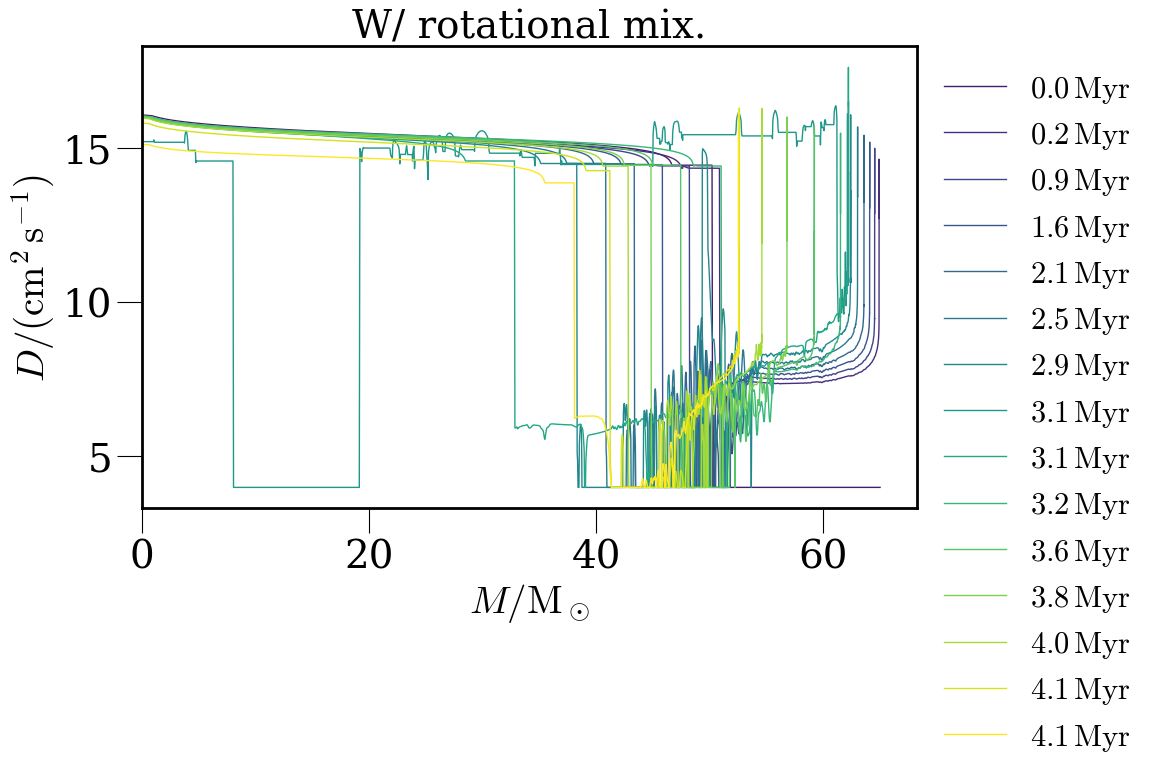

In [183]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.viridis(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_D_mix, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0)
    
    

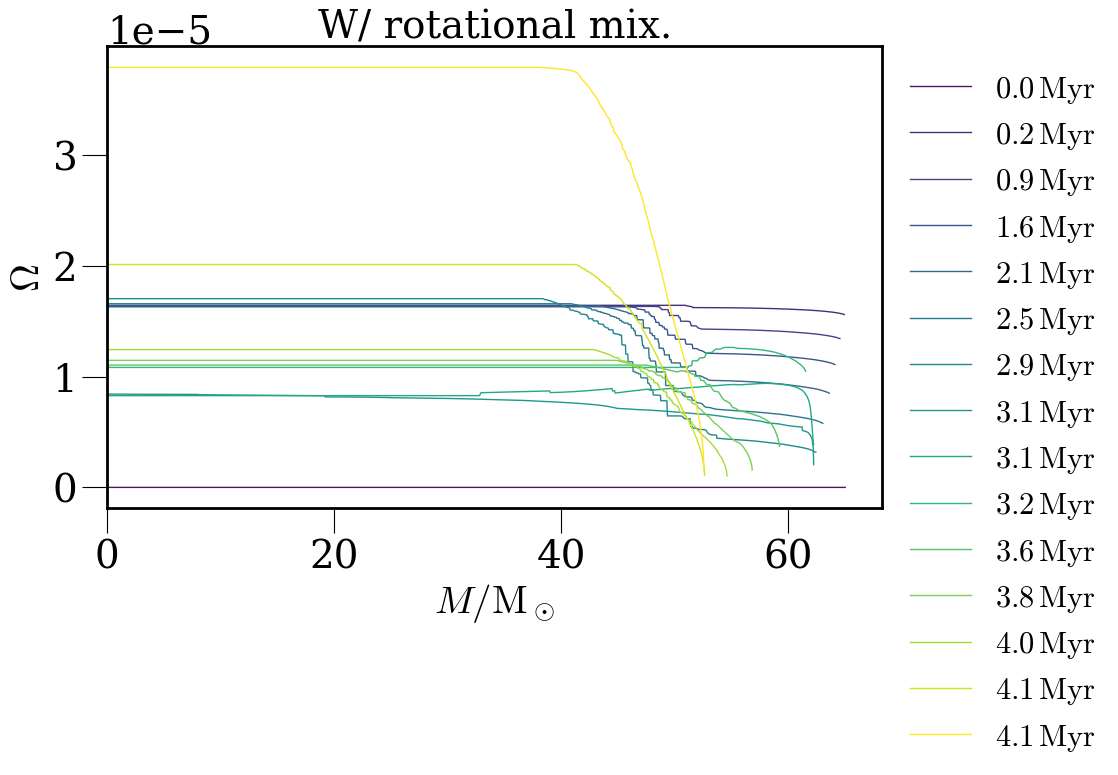

In [184]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.viridis(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.omega, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    ax.set_xlim(0)
    
    

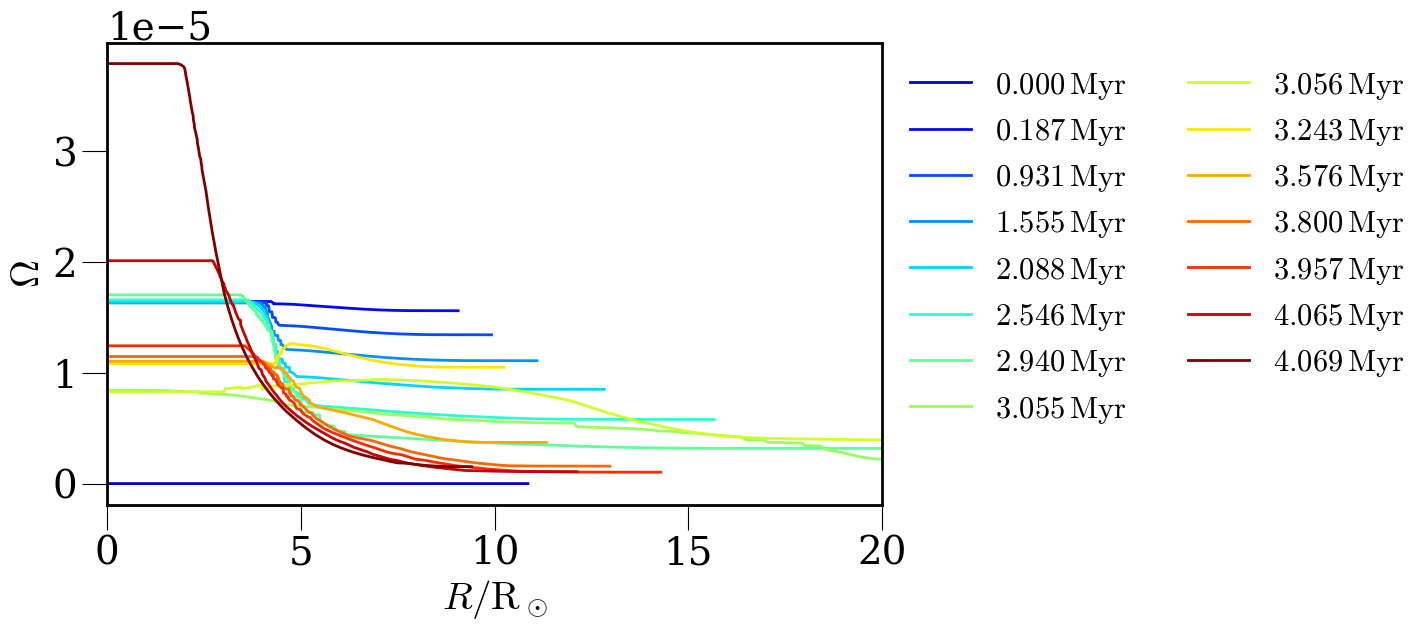

In [192]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    ax.set_xlim(0, 20)
    
    

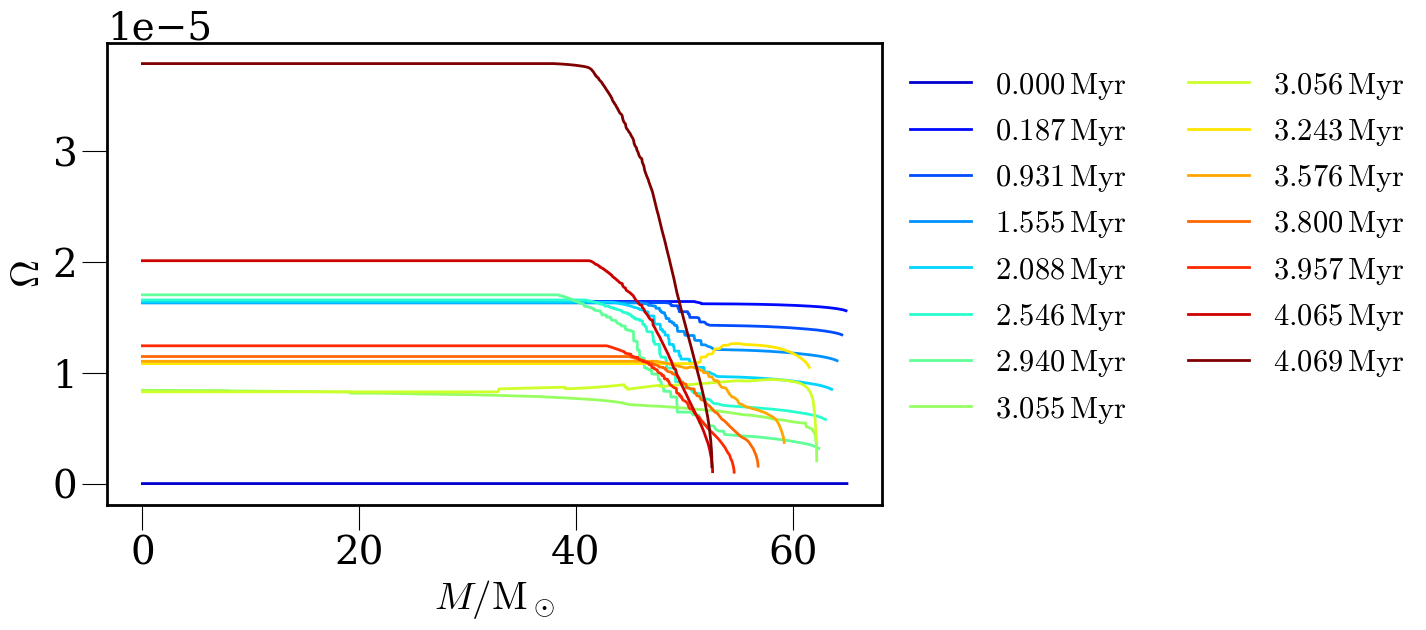

In [194]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    #ax.set_xlim(0, 20)
    
    

In [58]:
def tau_mix(prof):
    mix_types = prof.mixing_type
    first_overshoot_i = np.where(mix_types == 2)[0][0]

    r = prof.radius[:first_overshoot_i]
    d = 10.**prof.log_D_mix[:first_overshoot_i]
    d_nonrot = 10.**prof.log_D_mix_non_rotation[:first_overshoot_i]
    h_p = prof.pressure_scale_height[:first_overshoot_i] * u.Rsun.to(u.cm)
    dt_mix = h_p**2 / d
    dt_mix_nonrot = h_p**2 / d_nonrot

    mix_tscale = -simpson(x=r, y=dt_mix) * u.s.to(u.yr)
    mix_tscale_nonrot = -simpson(x=r, y=dt_mix_nonrot) * u.s.to(u.yr)

    return mix_tscale, mix_tscale_nonrot

In [59]:
all_paths = [model_dict[k1][k2] for k1 in model_dict.keys() for k2 in model_dict[k1].keys()] 

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

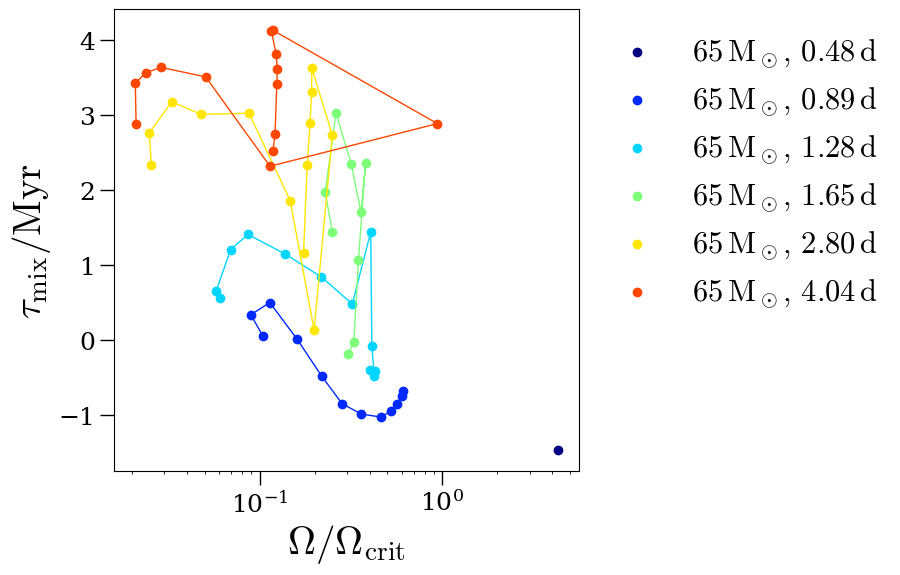

In [82]:
fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.omega_div_omega_crit[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

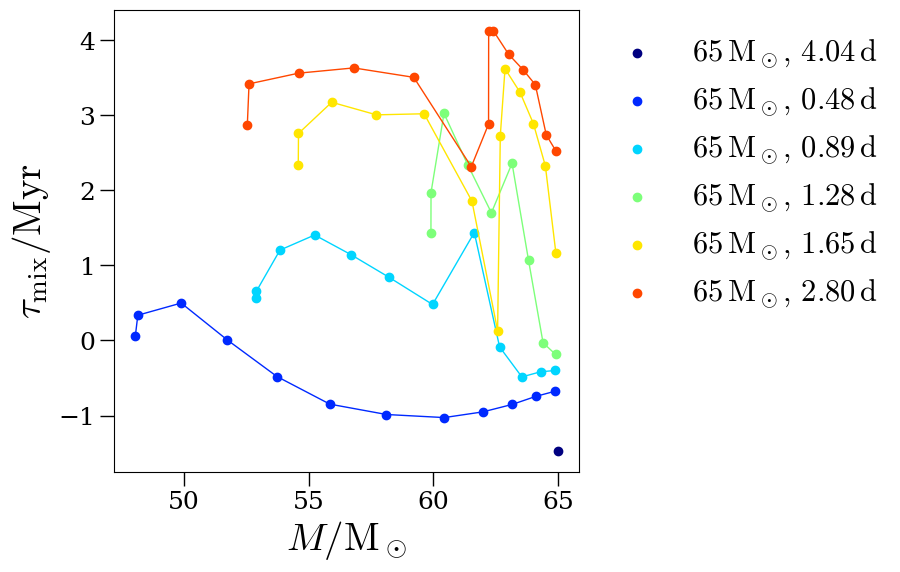

In [62]:

fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.mass[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
#ax.set_xscale('log')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

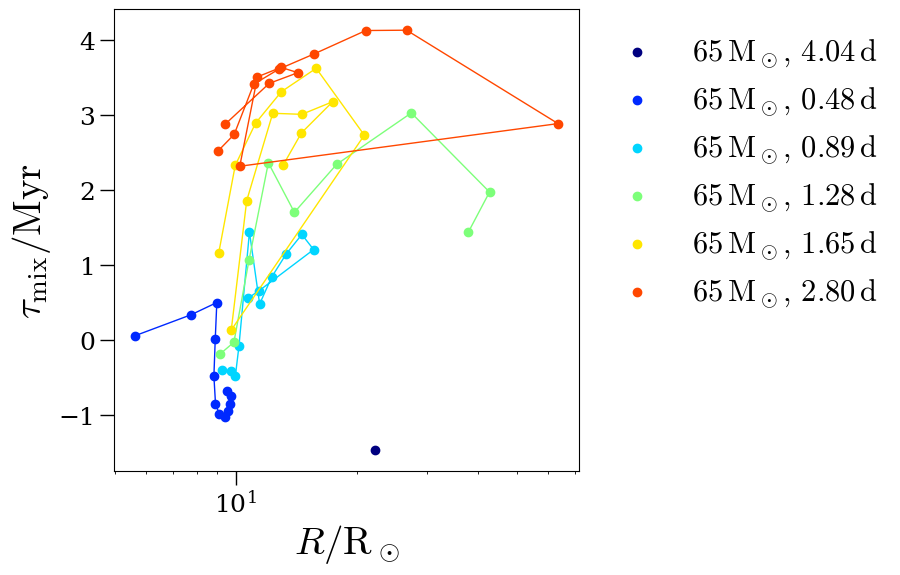

In [63]:
fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.radius[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

In [64]:
def get_plot_points(x, y):
    plot_points = list()
    for n in profiles.profile_numbers:
        if n == 1:
            continue
        elif n == 10:
            break
        prof = profiles.profile_data(profile_number=n)
        tmix, _ = tau_mix(prof)
        if y == 'tmix':
            plot_points.append([prof.__getattr__(x)[0], np.log10(tmix/1e6), prof.y_mass_fraction_He[0]])
        else:
            plot_points.append([prof.__getattr__(x)[0], prof.__getattr__(y)[0], prof.y_mass_fraction_He[0]])
    plot_points = np.array(plot_points)
    return plot_points

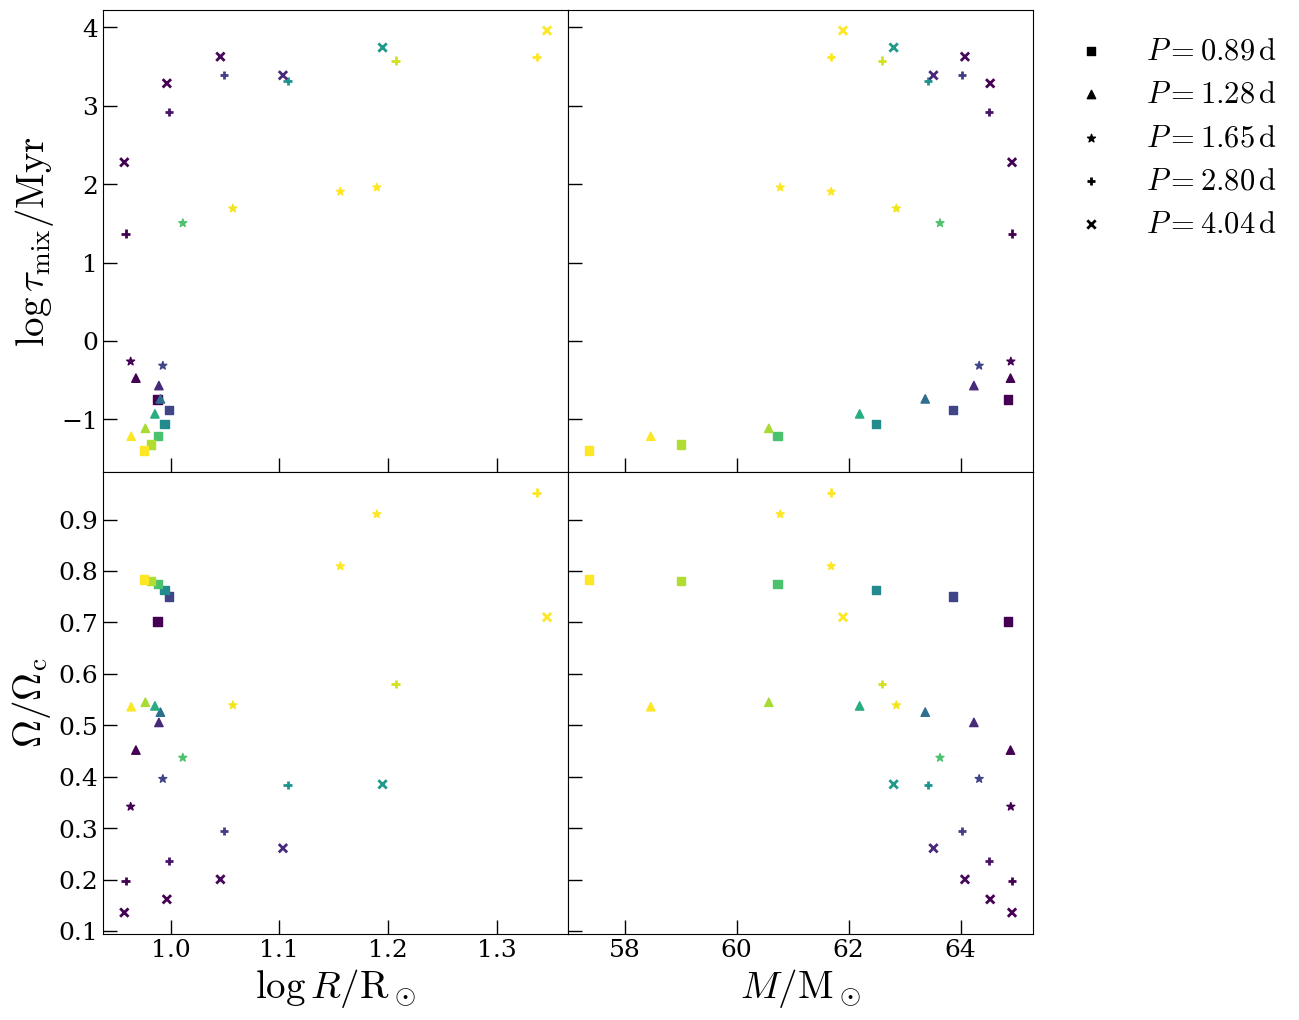

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
markers = ['o', 's', '^', '*', '+', 'x']

for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for i, p_key in enumerate(p_keys):
        if i == 0:
            continue
        marker = markers[i]
        
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        
        plot_points = get_plot_points('radius', 'tmix')
        axes[0, 0].scatter(np.log10(plot_points[:,0]), plot_points[:,1], c=plot_points[:,2], marker=marker)
        
        plot_points = get_plot_points('mass', 'tmix')
        axes[0, 1].scatter(plot_points[:,0], plot_points[:,1], c=plot_points[:,2], marker=marker)
        
        plot_points = get_plot_points('radius', 'omega_div_omega_crit')
        axes[1, 0].scatter(np.log10(plot_points[:,0]), plot_points[:,1], c=plot_points[:,2], marker=marker)
        
        plot_points = get_plot_points('mass', 'omega_div_omega_crit')
        axes[1, 1].scatter(plot_points[:,0], plot_points[:,1], c=plot_points[:,2], marker=marker)
        
        handles.append(ax.scatter([], [], color='k', marker=marker, label=f'$P={p:.2f}\\,\\mathrm{{d}}$'))
    
    axes[0, 1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    axes[0, 0].set_ylabel('$\\log\\tau_\\mathrm{mix}/\\mathrm{Myr}$')
    axes[1, 0].set_ylabel('$\\Omega/\\Omega_\\mathrm{c}$')
    axes[1, 0].set_xlabel('$\\log R/\\mathrm{R}_\\odot$')
    axes[1, 1].set_xlabel('$M/\\mathrm{M}_\\odot$')
        
    for ax in axes.flatten():
        ax.tick_params(direction='in')

In [47]:
def get_plot_points(x, y):
    plot_points = list()
    for n in profiles.profile_numbers:
        if n == 1:
            continue
        prof = profiles.profile_data(profile_number=n)
        tmix, _ = tau_mix(prof)
        if y == 'tmix':
            plot_points.append([prof.__getattr__(x)[0], np.log10(tmix/1e6), prof.y_mass_fraction_He[0]])
        else:
            plot_points.append([prof.__getattr__(x)[0], prof.__getattr__(y)[0], prof.y_mass_fraction_He[0]])
    plot_points = np.array(plot_points)
    return plot_points

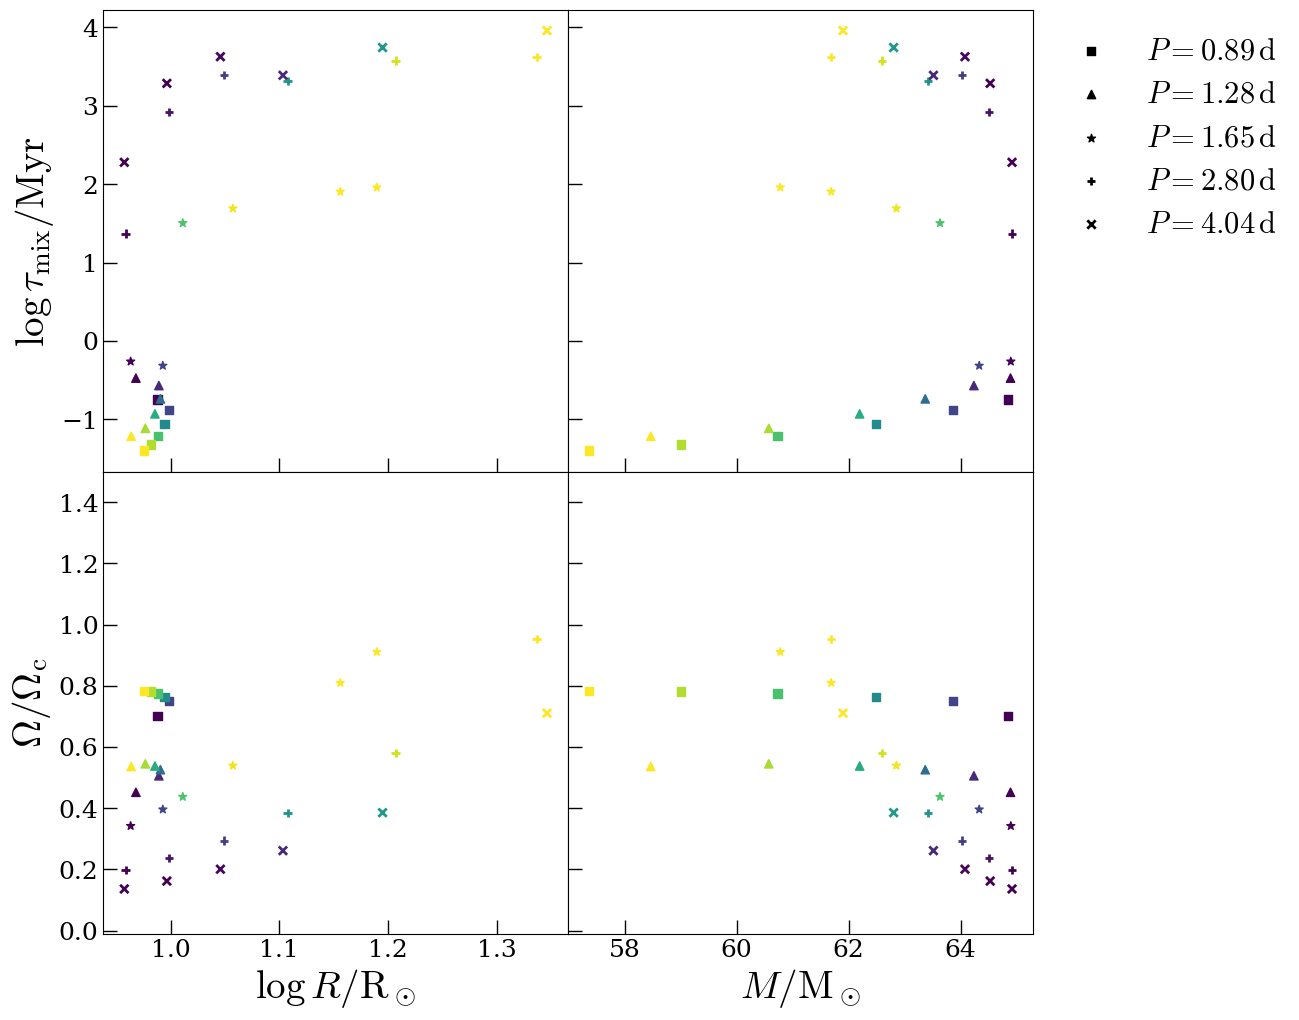

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
markers = ['o', 's', '^', '*', '+', 'x']

for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    handles = []
    for i, p_key in enumerate(p_keys):
        if i == 0:
            continue
        marker = markers[i]
        
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        
        plot_points = get_plot_points('radius', 'tmix')
        axes[0, 0].scatter(np.log10(plot_points[:,0]), plot_points[:,1], c=plot_points[:,2], marker=marker)
        
        plot_points = get_plot_points('mass', 'tmix')
        axes[0, 1].scatter(plot_points[:,0], plot_points[:,1], c=plot_points[:,2], marker=marker)
        
        plot_points = get_plot_points('radius', 'omega_div_omega_crit')
        axes[1, 0].scatter(np.log10(plot_points[:,0]), plot_points[:,1], c=plot_points[:,2], marker=marker)
        
        plot_points = get_plot_points('mass', 'omega_div_omega_crit')
        axes[1, 1].scatter(plot_points[:,0], plot_points[:,1], c=plot_points[:,2], marker=marker)
        
        handles.append(ax.scatter([], [], color='k', marker=marker, label=f'$P={p:.2f}\\,\\mathrm{{d}}$'))
    
    axes[0, 1].legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    axes[0, 0].set_ylabel('$\\log\\tau_\\mathrm{mix}/\\mathrm{Myr}$')
    axes[1, 0].set_ylabel('$\\Omega/\\Omega_\\mathrm{c}$')
    axes[1, 0].set_xlabel('$\\log R/\\mathrm{R}_\\odot$')
    axes[1, 1].set_xlabel('$M/\\mathrm{M}_\\odot$')
    
    axes[1, 0].set_ylim(-0.01, 1.5)
        
    for ax in axes.flatten():
        ax.tick_params(direction='in')

In [1]:
import mesaPlot

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <